In [344]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.integrate as integrate

from astropy import units as u 
from astropy.table import Table

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.models.ccsn import Zha_2021
from snewpy.models.ccsn import Tamborra_2014
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
from asteria import set_rcparams
from asteria.simulation import Simulation

%matplotlib inline

C:\Users\sanya\AppData\Local\Temp\ipykernel_32424\2285163552.py:14: FutureWarning: snewpy.models.Nakazato_2013 is moved to snewpy.models.ccsn.Nakazato_2013
  from snewpy.models import Nakazato_2013


In [16]:
sukh_param_sfho=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='SFHo')
sukh_param_ls220=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')


forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 26.99)

zha_param=list(params for params in Zha_2021.get_param_combinations() if params['progenitor_mass'].value == 26)

tamb_param=list(params for params in Tamborra_2014.get_param_combinations() if params['progenitor_mass'].value == 27
               and params['direction']==1)


In [17]:
sukh_model_sfho = {'name': 'Sukhbold_2015',
            'param': sukh_param_sfho[0]
              }

sukh_model_ls220 = {'name': 'Sukhbold_2015',
            'param': sukh_param_ls220[0]
              }

forn_model = {'name': 'Fornax_2022',
            'param': forn_param[0]
              }

zha_model = {'name': 'Zha_2021',
            'param': zha_param[0]
              }

tamb_model = {'name': 'Tamborra_2014',
            'param': tamb_param[0]
              }

In [24]:
models=[sukh_model_sfho,sukh_model_ls220,forn_model,zha_model,tamb_model]
labels=['nmo','imo']
hie=['normal','inverted']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

sims = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        if mod['name']=='Fornax_2022':
            with open("{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                    lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))
        else:
            with open("{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))

In [317]:
def compute_chi_sq(pred,dat,dt,sim):
    t=dt.to(u.s).value
    bg_var=(26.2*np.sqrt(t*sim.detector.n_i3_doms))**2 + (36*np.sqrt(t*sim.detector.n_dc_doms))**2
    chi_sq=0
    for i in range(len(pred)):
        chi_sq += ((pred[i]-dat[i])**2)/(dat[i]+bg_var)
    return chi_sq

In [318]:
def compute_hits(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]
    data_norm=data/np.sum(data)
    return data

In [345]:
def compute_hits_scaled(scale,dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]
    
    data_scaled=data*scale
    return data_scaled

In [319]:
def compute_hits_with_bg(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    bg1 = sim.detector.i3_bg(dt,size=hits.size) + sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id1=np.where(t==-5*u.s)[0][0]
    id2=np.where(t==-.5*u.s)[0][0]
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]

    mean_under=np.mean(sig[id1:id2])
    data_hits=np.subtract(sig,mean_under)[id5:id6]
    
    data_norm=data_hits/np.sum(data_hits)
    return data_hits

In [226]:
t, hits = sims['sukh_sfho'][0].detector_signal(dt)
bg1 = sims['sukh_sfho'][0].detector.i3_bg(dt,size=hits.size) + sims['sukh_sfho'][0].detector.dc_bg(dt,size=hits.size)
sig=bg1+hits
id1=np.where(t==-5*u.s)[0][0]
id2=np.where(t==-.5*u.s)[0][0]
id5=np.where(t==.02*u.s)[0][0]
id6=np.where(t==.46*u.s)[0][0]

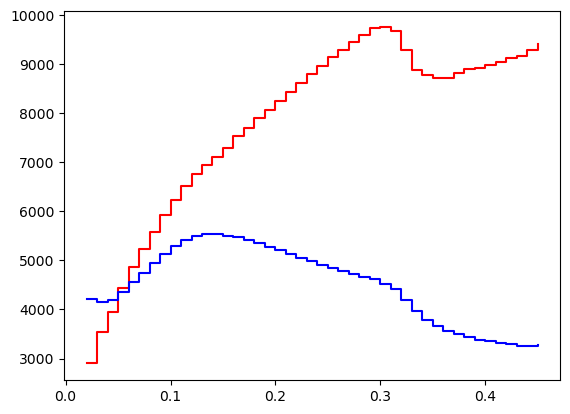

In [343]:
sim_hits = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,name in enumerate(mod_names):
    sim_hits[name].append(compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][0]))
    sim_hits[name].append(compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][1]))


plt.step(t[id5:id6], sim_hits['zha'][0], where='post',color='red',label='zha nh')
plt.step(t[id5:id6], sim_hits['zha'][1], where='post',color='blue',label='zha ih')

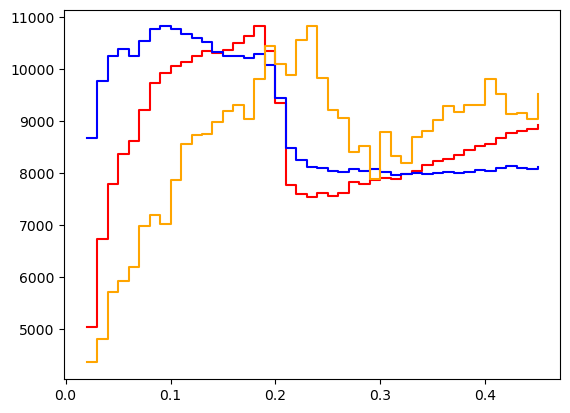

In [456]:

data_hits=compute_hits_with_bg(dist,dt,.02*u.s,.46*u.s,sims['forn'][0])
sim_hits = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,name in enumerate(mod_names):
    model0=compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][0])
    model1=compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][1])
    sim_hits[name].append(compute_hits_scaled(np.max(data_hits)/np.max(model0),dist,dt,.02*u.s,.46*u.s,sims[name][0]))
    sim_hits[name].append(compute_hits_scaled(np.max(data_hits)/np.max(model1),dist,dt,.02*u.s,.46*u.s,sims[name][1]))


plt.step(t[id5:id6], sim_hits['sukh_sfho'][0], where='post',color='red',label='zha nh')
plt.step(t[id5:id6], sim_hits['sukh_sfho'][1], where='post',color='blue',label='zha ih')
plt.step(t[id5:id6], data_hits, where='post',color='orange',label='data')

In [323]:
def compute_probs(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    probs=[]
    mod_names=model_sims.keys()
    sim_hits = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
    for i,name in enumerate(mod_names):
        sim_hits[name].append(compute_hits_norm(dist,dt,.02*u.s,.46*u.s,model_sims[name][0]))
        sim_hits[name].append(compute_hits_norm(dist,dt,.02*u.s,.46*u.s,model_sims[name][1]))
    for j in range(errs):
        data_hits=compute_hits_with_bg_norm(dist,dt,.02*u.s,.46*u.s,data_sim)
        prob=0
        for k,name in enumerate(mod_names):
            p_d_nh=np.exp(-.5*compute_chi_sq(sim_hits[name][0],data_hits,dt,data_sim))
            p_d_ih=np.exp(-.5*compute_chi_sq(sim_hits[name][1],data_hits,dt,data_sim))
            if(hierarchy==0):
                prob+= p_d_nh/(p_d_nh+p_d_ih)*priors[k]
            else:
                prob+= p_d_ih/(p_d_ih+p_d_nh)*priors[k]
        probs.append(prob)
    return probs

In [405]:
def compute_probs_scaled(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    probs=[]
    mod_names=model_sims.keys()
    
    for j in range(errs):
        data_hits=compute_hits_with_bg(dist,dt,.02*u.s,.46*u.s,data_sim)
        prob=0
        sim_hits = {
            'sukh_sfho': [],
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
        }
        for k,name in enumerate(sim_hits.keys()):
            model0=compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][0])
            model1=compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][1])
            sim_hits[name].append(compute_hits_scaled(np.max(data_hits)/np.max(model0),dist,dt,.02*u.s,.46*u.s,model_sims[name][0]))
            sim_hits[name].append(compute_hits_scaled(np.max(data_hits)/np.max(model1),dist,dt,.02*u.s,.46*u.s,model_sims[name][1]))

            p_d_nh=np.exp(-.5*compute_chi_sq(sim_hits[name][0],data_hits,dt,data_sim))
            p_d_ih=np.exp(-.5*compute_chi_sq(sim_hits[name][1],data_hits,dt,data_sim))
            
            if(hierarchy==0):
                prob+= p_d_nh/(p_d_nh+p_d_ih)*priors[k]
            else:
                prob+= p_d_ih/(p_d_ih+p_d_nh)*priors[k]
        probs.append(prob)
    return probs

In [346]:
def scale_integrand(scale, data, model_sim, dt, a, b):
    scaled_model=compute_hits_scaled(scale,dist,dt,.02*u.s,.46*u.s,model_sim)
    
    return np.exp(-.5*compute_chi_sq(scaled_model,data,dt,model_sim)+np.log(1/(b-a)))

In [420]:
def compute_prob_with_scale(data,model_sim,dt,dist):
    model=compute_hits(dist,dt,.02*u.s,.46*u.s,model_sim)
    
    r = np.max(data) - np.min(data)
    a = (np.min(data)-r)/np.max(model)
    if(a<0):
        a=0
    b = (np.max(data)+r)/np.max(model)
    
    result, error = integrate.quad(scale_integrand, a, b, args=(data, model_sim, dt, a, b))
    
    return result

In [448]:
data=compute_hits_with_bg(dist,dt,.02*u.s,.46*u.s, sims['sukh_ls220'][0])
compute_prob_with_scale(data,sims['sukh_ls220'][1],dt,dist)

1.4634774191786978e-128

Text(0, 0.5, 'likelihood')

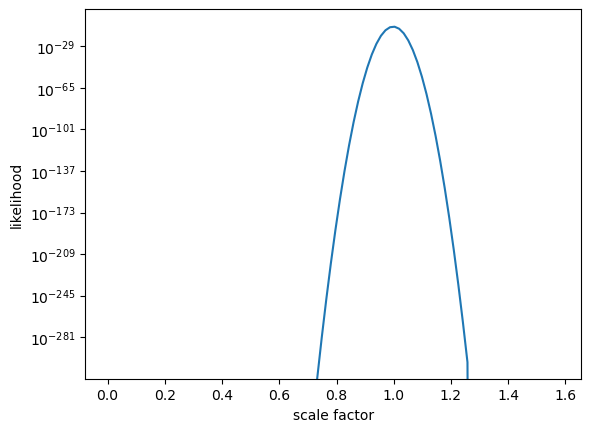

In [458]:
data=compute_hits_with_bg(dist,dt,.02*u.s,.46*u.s, sims['sukh_sfho'][0])
model=compute_hits(dist,dt,.02*u.s,.46*u.s, sims['sukh_sfho'][0])
    
r = np.max(data) - np.min(data)
a = (np.min(data)-r)/np.max(model)
if(a<0):
    a=0
b = (np.max(data)+r)/np.max(model)

results=[]
scales=np.linspace(a,b,100)
for i,scale in enumerate(scales):
    result = scale_integrand(scale, data, sims['sukh_sfho'][0], dt, a, b)
    results.append(result)
    
plt.plot(scales,np.array(results))
plt.yscale('log')
plt.xlabel('scale factor')
plt.ylabel('likelihood')

In [451]:
def probs_with_scale(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    probs=[]
    for j in range(errs):
        data_hits=compute_hits_with_bg_norm(dist,dt,.02*u.s,.46*u.s,data_sim)
        prob=0
        for k,name in enumerate(model_sims.keys()):
            p_d_nh=compute_prob_with_scale(data_hits,model_sims[name][0],dt,dist)
            p_d_ih=compute_prob_with_scale(data_hits,model_sims[name][1],dt,dist)
            if(hierarchy==0):
                prob+= p_d_nh/(p_d_nh+p_d_ih)*priors[k]
            else:
                prob+= p_d_ih/(p_d_ih+p_d_nh)*priors[k]
        probs.append(prob)
            
    return probs

In [325]:
def compute_odds_ratio(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    ratios=[]
    mod_names=model_sims.keys()
    sim_hits = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
    for i,name in enumerate(mod_names):
        sim_hits[name].append(compute_hits_norm(dist,dt,.02*u.s,.46*u.s,model_sims[name][0]))
        sim_hits[name].append(compute_hits_norm(dist,dt,.02*u.s,.46*u.s,model_sims[name][1]))
    for j in range(errs):
        data_hits=compute_hits_with_bg_norm(dist,dt,.02*u.s,.46*u.s,data_sim)
        prob_nh=0
        prob_ih=0
        for k,name in enumerate(mod_names):
            p_d_nh=np.exp(-.5*compute_chi_sq(sim_hits[name][0],data_hits,dt,data_sim))
            p_d_ih=np.exp(-.5*compute_chi_sq(sim_hits[name][1],data_hits,dt,data_sim))
            
            prob_nh += p_d_nh/(p_d_nh+p_d_ih)*priors[k]
            prob_ih += p_d_ih/(p_d_ih+p_d_nh)*priors[k]
        if(hierarchy==0):
            ratios.append(prob_nh/prob_ih)
        if(hierarchy==1):
            ratios.append(prob_ih/prob_nh)
    return ratios

In [87]:
def compute_p_val(area_tot,start,params,stat,chis_nh,bin_width):
    a,b=params
    upper=-1/a*(5000+b)
    lower=stat
    if(lower<start):
        area=len(chis_nh[np.logical_and(chis_nh>stat,chis_nh<start)])*bin_width+1/a*(np.exp(a*upper+b)-np.exp(a*start+b))
    else:
        area=1/a*(np.exp(a*upper+b)-np.exp(a*lower+b))
    area_full=.9*area_tot*bin_width + 1/a*(np.exp(a*upper+b)-np.exp(a*start+b))
    return area/area_full

In [88]:
def quad_fit(x, a, b):
    return a*x + b

In [190]:
def dist_to_pvals(data_sim,model_sims,priors,dist,dt,errs):
    
    
    probs_nh=compute_probs(data_sim,model_sims,priors,dist,dt,hierarchy=0,errs=errs)
    probs_ih=compute_probs(data_sim,model_sims,priors,dist,dt,hierarchy=1,errs=errs)

    probs_nh=np.array(probs_nh)
    probs_ih=np.array(probs_ih)
    
    if(np.median(probs_nh)<=np.median(probs_ih)):
        hist_nh, bin_edges_nh = np.histogram(probs_nh, bins=24)
        hist_ih, bin_edges_ih = np.histogram(probs_ih, bins=24)
        bin_width_nh = bin_edges_nh[1] - bin_edges_nh[0]

        cumulative_nh = np.cumsum(hist_nh)
        split_nh = np.searchsorted(cumulative_nh, .9*errs)

        tail_region_nh = slice(-(len(hist_nh)-split_nh), None)

        params_nh, cov_nh = curve_fit(quad_fit, bin_edges_nh[tail_region_nh], np.log(hist_nh[tail_region_nh]+1))
        a_nh, b_nh = params_nh

        p_vals=[]
        for i,prob_ih in enumerate(probs_ih):
            p=compute_p_val(errs,bin_edges_nh[split_nh],params_nh,prob_ih,probs_nh,bin_width_nh)
            p_vals.append(p)
            
        x_nh=np.linspace(bin_edges_nh[split_nh],
                         bin_edges_nh[split_nh]+.01,500)
        y_fit_nh = np.exp(a_nh*x_nh+b_nh)
        
        plt.hist(probs_nh, alpha=0.5, edgecolor='blue', 
                linewidth=1.5,label='NH',bins=16)
        plt.hist(probs_ih, alpha=0.5, color='red', edgecolor='red', 
                linewidth=1.5,label='IH',bins=16)
        plt.plot(x_nh, y_fit_nh, color='blue', label='NH fit')

        return -1*np.array([norm.isf(np.median(p_vals)),
                    norm.isf(np.percentile(p_vals, 16)),
                    norm.isf(np.percentile(p_vals, 84))])
        #return norm.isf(np.median(p_vals))
    else:
        hist_nh, bin_edges_nh = np.histogram(probs_nh, bins=24)
        hist_ih, bin_edges_ih = np.histogram(probs_ih, bins=24)
        bin_width_ih = bin_edges_ih[1] - bin_edges_ih[0]

        cumulative_ih = np.cumsum(hist_ih)
        split_ih = np.searchsorted(cumulative_ih, .9*errs)

        tail_region_ih = slice(-(len(hist_ih)-split_ih), None)

        params_ih, cov_ih = curve_fit(quad_fit, bin_edges_ih[tail_region_ih], np.log(hist_ih[tail_region_ih]+1))
        a_ih, b_ih = params_ih

        p_vals=[]
        for i,prob_nh in enumerate(probs_nh):
            p=compute_p_val(errs,bin_edges_ih[split_ih],params_ih,prob_nh,probs_ih,bin_width_ih)
            p_vals.append(p)
            
        x_ih=np.linspace(bin_edges_ih[split_ih],
                         bin_edges_ih[split_ih]+.01,500)
        y_fit_ih = np.exp(a_ih*x_ih+b_ih)
        
        plt.hist(probs_nh, alpha=0.5, edgecolor='blue', 
                linewidth=1.5,label='NH',bins=16)
        plt.hist(probs_ih, alpha=0.5, color='red', edgecolor='red', 
                linewidth=1.5,label='IH',bins=16)
        plt.plot(x_ih, y_fit_ih, color='red', label='IH fit')

        return np.array([norm.isf(np.median(p_vals)),
                    norm.isf(np.percentile(p_vals, 16)),
                    norm.isf(np.percentile(p_vals, 84))])
        #return -1*norm.isf(np.median(p_vals))

In [452]:
data_sim=sims['sukh_sfho'][0]
priors=[.2,.2,.2,.2,.2]
#priors=[.9,.025,.025,.025,.025]
probs_nh=probs_with_scale(sims['forn'][0],sims,priors,10*u.kpc,10*u.ms,hierarchy=0,errs=100)
probs_ih=probs_with_scale(sims['forn'][0],sims,priors,10*u.kpc,10*u.ms,hierarchy=1,errs=100)

plt.hist(probs_nh,alpha=.5,edgecolor='blue')
plt.hist(probs_ih,color='red',alpha=.5,edgecolor='red')

ZeroDivisionError: float division by zero

In [271]:
np.exp(-.5*2000)

0.0

(array([31.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0., 66.]),
 array([1.48984533e-50, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

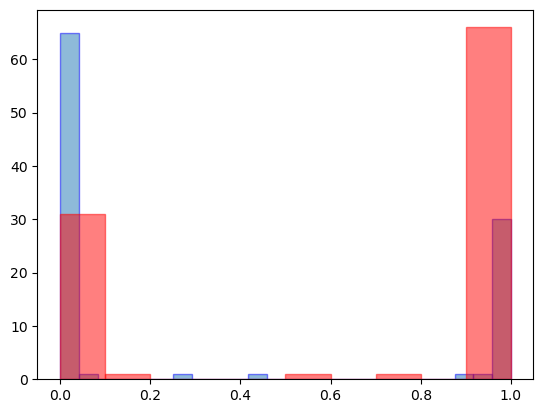

In [416]:
prob_nh=0
prob_ih=0

dist=10*u.kpc
dt=10*u.ms

prob_nh=[]
prob_ih=[]
name='tamb'
for i in range(100):
    data_hits=compute_hits_with_bg(dist,dt,.02*u.s,.46*u.s,sims['sukh_sfho'][0])
    
    model0=compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][0])
    model1=compute_hits(dist,dt,.02*u.s,.46*u.s,sims[name][1])
        
    sim_hits0=compute_hits_scaled(np.max(data_hits)/np.max(model0),dist,dt,.02*u.s,.46*u.s,sims[name][0])
    sim_hits1=compute_hits_scaled(np.max(data_hits)/np.max(model1),dist,dt,.02*u.s,.46*u.s,sims[name][1])
    

    p_d_nh= np.exp(-.5*compute_chi_sq(sim_hits0,data_hits,dt,sims[name][0]))
    p_d_ih=np.exp(-.5*compute_chi_sq(sim_hits1,data_hits,dt,sims[name][0]))
    
    prob_nh.append(p_d_nh/(p_d_nh+p_d_ih))
    prob_ih.append(p_d_ih/(p_d_ih+p_d_nh))
    ratios.append((p_d_nh/(p_d_nh+p_d_ih))/(p_d_ih/(p_d_ih+p_d_nh)))
    

plt.hist(prob_nh,alpha=.5,edgecolor='blue',bins=24)
plt.hist(prob_ih,color='red',alpha=.5,edgecolor='red')
#plt.xlim(0,.1)
#prob_nh

In [331]:
compute_prob_with_scale(data_sim,model_sim,dt,dist)

15001.553003653518

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.]),
 array([0.99999962, 0.99999966, 0.9999997 , 0.99999973, 0.99999977,
        0.99999981, 0.99999985, 0.99999989, 0.99999992, 0.99999996,
        1.        ]),
 <BarContainer object of 10 artists>)

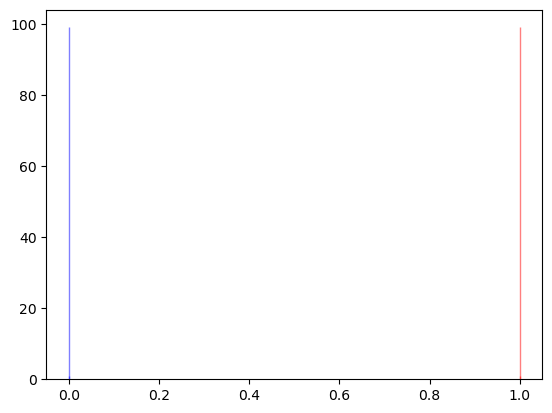

In [404]:
prob_nh=0
prob_ih=0

dist=10*u.kpc
dt=10*u.ms

prob_nh=[]
prob_ih=[]
for i in range(100):
    #data_hits=compute_hits_with_bg_norm(dist,dt,.02*u.s,.46*u.s,sims['sukh_sfho'][0])
    
    #sim_hits0=compute_hits_scaled(np.max(data_hits),dist,dt,.02*u.s,.46*u.s,sims['sukh_sfho'][0])
    #sim_hits1=compute_hits_scaled(np.max(data_hits),dist,dt,.02*u.s,.46*u.s,sims['sukh_sfho'][1])
    

    p_d_nh= compute_prob_with_scale(sims['sukh_sfho'][0],sims['forn'][0],dt,dist)
    p_d_ih= compute_prob_with_scale(sims['sukh_sfho'][0],sims['forn'][1],dt,dist)
    #print(p_d_nh)
    #print(p_d_ih)
    prob_nh.append(p_d_nh/(p_d_nh+p_d_ih))
    prob_ih.append(p_d_ih/(p_d_ih+p_d_nh))

    #ratios.append((p_d_nh/(p_d_nh+p_d_ih))/(p_d_ih/(p_d_ih+p_d_nh)))
    
#print(prob_nh,prob_ih)
plt.hist(prob_nh,alpha=.5,edgecolor='blue',bins=24)
plt.hist(prob_ih,color='red',alpha=.5,edgecolor='red')

In [239]:
compute_chi_sq(sim_hits1,data_hits)

0.12346140346146293

Text(0, 0.5, 'Counts')

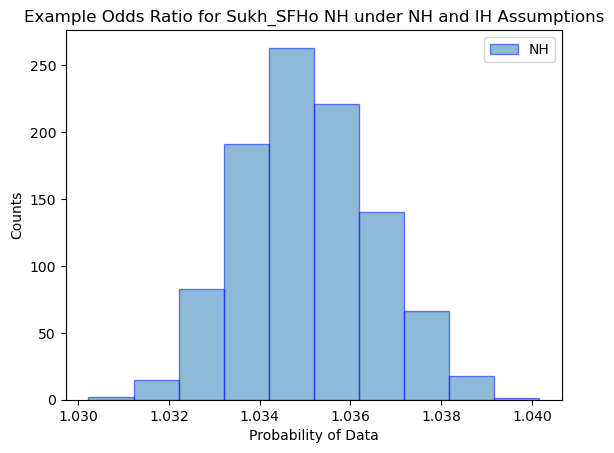

In [206]:
data_sim=sims['zha'][0]
priors=[1,1,1,1,1]
#priors=[.8,.05,.05,.05,.05]
ratios=compute_odds_ratio(data_sim,sims,priors,10*u.kpc,10*u.ms,hierarchy=0,errs=1000)

plt.hist(ratios,alpha=.5,edgecolor='blue',label='NH')
plt.legend()
plt.title('Example Odds Ratio for Sukh_SFHo NH under NH and IH Assumptions')
plt.xlabel('Probability of Data')
plt.ylabel('Counts')

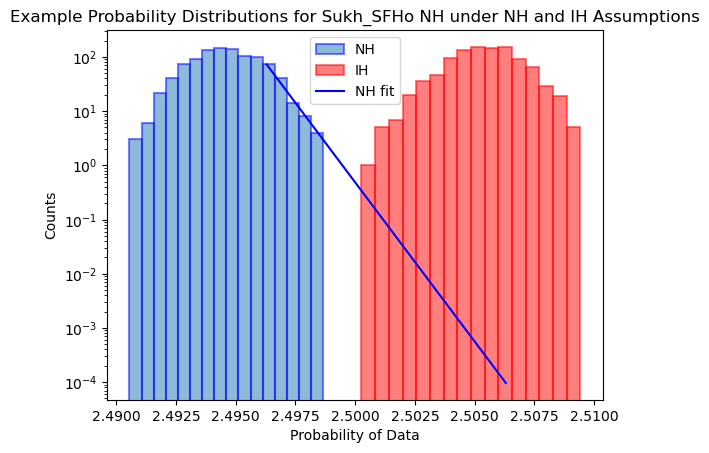

In [193]:
#priors=[,.05,.05,.05,.05]
dist_to_pvals(data_sim,sims,priors,10*u.kpc,10*u.ms,1000)
plt.legend()
plt.title('Example Probability Distributions for Sukh_SFHo NH under NH and IH Assumptions')
plt.xlabel('Probability of Data')
plt.ylabel('Counts')
plt.yscale('log')

array([5.54883651, 5.86618727, 5.22410699])

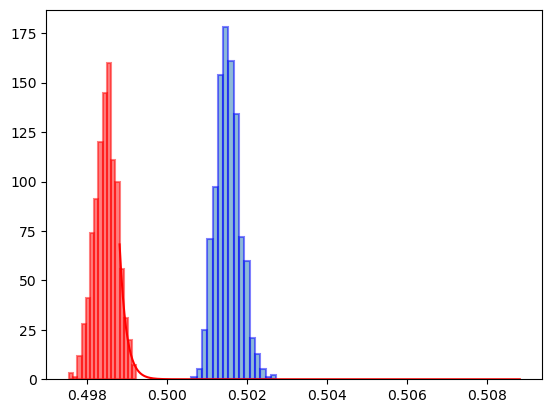

In [178]:
priors=[.9,.025,.025,.025,.025]
dist_to_pvals(data_sim,sims,priors,10*u.kpc,10*u.ms,1000)

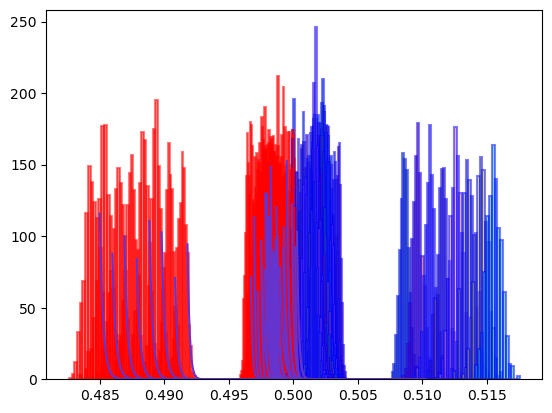

In [167]:
prior_list=np.linspace(.2,.9,8)
sigs={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,mod_name in enumerate(sigs.keys()):
    for j,prior in enumerate(prior_list):
        priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
        priors[i]=prior
        p_vals_nh=dist_to_pvals(sims[mod_name][0],sims,priors,10*u.kpc,10*u.ms,1000)
        p_vals_ih=-1*dist_to_pvals(sims[mod_name][1],sims,priors,10*u.kpc,10*u.ms,1000)
        if(p_vals_ih[0]<p_vals_nh[0]):
            sigs[mod_name].append(p_vals_ih)
        else:
            sigs[mod_name].append(p_vals_nh)

Text(0, 0.5, 'Hierarchy Sensitivity')

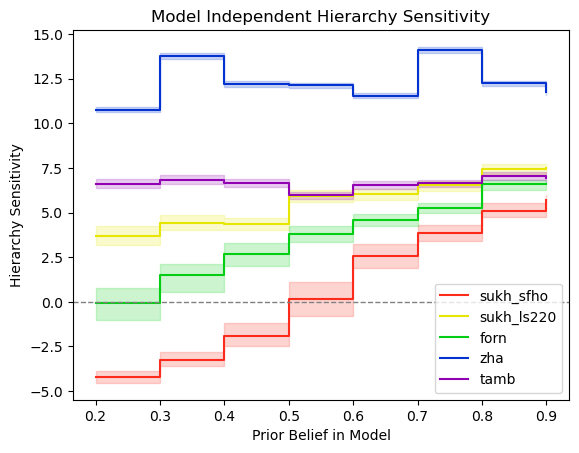

In [173]:
colors=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
for i,mod_name in enumerate(sigs.keys()):
    plt.step(prior_list,[meds[0] for meds in sigs[mod_name]],color=colors[i],where='post',label=mod_name)
    plt.fill_between(prior_list, [meds[1] for meds in sigs[mod_name]], 
                     [meds[2] for meds in sigs[mod_name]],step='post',color=colors[i], alpha=0.2)
plt.legend()
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title('Model Independent Hierarchy Sensitivity')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Hierarchy Sensitivity')

In [201]:
prior_list=np.linspace(.2,.9,8)
ratios={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }
for i,mod_name in enumerate(sigs.keys()):
    for j,prior in enumerate(prior_list):
        priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
        priors[i]=prior
        ratios_nh=compute_odds_ratio(sims[mod_name][0],sims,priors,10*u.kpc,10*u.ms,0,1000)
        ratios_ih=compute_odds_ratio(sims[mod_name][1],sims,priors,10*u.kpc,10*u.ms,1,1000)
        if(np.median(ratios_ih)<np.median(ratios_nh)):
            ratios[mod_name].append([np.median(ratios_ih),
                    np.percentile(ratios_ih, 16),
                    np.percentile(ratios_ih, 84)])
        else:
            ratios[mod_name].append([np.median(ratios_nh),
                    np.percentile(ratios_nh, 16),
                    np.percentile(ratios_nh, 84)])

Text(0, 0.5, 'Odds Ratio')

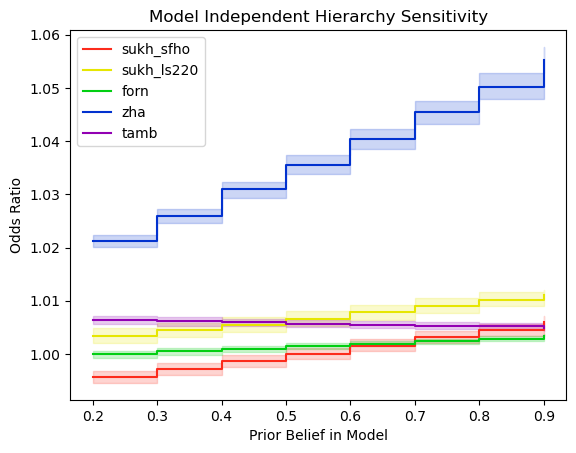

In [202]:
colors=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
for i,mod_name in enumerate(sigs.keys()):
    plt.step(prior_list,[meds[0] for meds in ratios[mod_name]],color=colors[i],where='post',label=mod_name)
    plt.fill_between(prior_list, [meds[1] for meds in ratios[mod_name]], 
                     [meds[2] for meds in ratios[mod_name]],step='post',color=colors[i], alpha=0.2)
plt.legend()
#plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title('Model Independent Hierarchy Sensitivity')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Odds Ratio')